In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
from tensorflow import math as tm
import kerastuner as kt
import tensorflow.keras.backend as kb
import math, time
from kerastuner.engine.hyperparameters import HyperParameters
from datetime import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [2]:
dtype = 'float64' # Faster as float32 but 32-bit may not be enough memory without normalization
tf.keras.backend.set_floatx(dtype)

In [3]:
#set hyperparameters
num_sample_points = 30
num_samples = 1*10**3
epoch_nums =32
minibatch = 16
horiz_aug = False
vert_aug = False

In [4]:
dropout = 0.2
reg1_rate = 0.001
reg2_rate = 0.001
learning_rate = 0.001
momentum = 0.5
num_layers = 2
units = 256
act_func = 'relu'

In [5]:
def data(sample_interval = [-4, 4], amplitude_interval = [-30,30]): #generate data

    sample = np.linspace(*sample_interval, num_sample_points)
    
    period = lambda: np.random.uniform(0.05, 10*np.pi)
    amplitude = lambda: np.random.uniform(*amplitude_interval)
    
    horiz_tran = lambda: 2*np.pi*np.random.uniform(0,int(horiz_aug)) # Worse performance with horizontal augmentation so (0,0) it
    vert_tran = lambda: 20*(np.random.uniform(0,int(vert_aug))-0.5) # Augmenting
    yAw = np.array([np.array([period(), amplitude()]) for i in range(num_samples)])
    curves = np.array([ vert_tran() + yAw[i][1] * np.sin( ( horiz_tran() + sample ) * (2*np.pi/yAw[i][0]) )
                       for i in range(num_samples) ])# Is it worth vectorizing this?
    if not vert_aug:
        curves = (curves.transpose() - np.mean(curves, axis=1)).transpose() # Pre-processes curves to centre them
    #curves /= np.max(np.abs(curves)) # Normalizing data would lose magnitude/amplitude information
    return [curves, yAw]
# Returns list of 2 arrays [x,y]:
# - x is an array of each curve sample list
# - y is an array of the period-amplitude pair for each curve sample in x

In [6]:
def model_builder():
    initializer = keras.initializers.HeNormal()
    
    model = keras.Sequential()
    model.add( keras.layers.Dense( units = num_sample_points, # Number of input nodes to match number of sample points
                                   kernel_initializer = initializer, # Initialize weights
                                   activation = act_func,
                                   kernel_regularizer = keras.regularizers.l2(reg2_rate), #L2 regularisation
                                   dtype=dtype))
    keras.layers.BatchNormalization()

    for layer in range(num_layers):
        keras.layers.Dropout(dropout)
        model.add( keras.layers.Dense( units = units,
                                       activation = act_func,
                                       kernel_regularizer = keras.regularizers.l2(reg2_rate),
                                       dtype=dtype))
        keras.layers.BatchNormalization() # Theory says to normalize after activation layer
        
    model.add( keras.layers.Dense(units = 2, activation = 'linear', dtype=dtype))
    # Outputting amplitude-period pair requires 2 nodes in the output layer.
    
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
        loss = 'mse',
        metrics = ['mse'] ) # Measures train&test performance
    return model

In [7]:
logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M-%S") #tensorboard 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [8]:
model = model_builder() #build model
df = data() #generate data


In [9]:
start = time.time()
training_history_1 = model.fit(*df,
                             batch_size = minibatch, 
                             epochs = epoch_nums,
                             verbose = 1, 
                             validation_split = 0.2, # Fraction of data used for validation set
                             callbacks=[tensorboard_callback])
end = time.time()
time_taken = end-start #calculate time taken

print("Time Taken (s) : ", time_taken)


Epoch 1/32
 1/50 [..............................] - ETA: 0s - loss: 235.2674 - mse: 234.9012WARNING:tensorflow:From C:\Users\benwo\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
50/50 [==============================] - ETA: 0s - loss: 115.6952 - mse: 115.336 - ETA: 0s - loss: 101.1839 - mse: 100.829 - ETA: 0s - loss: 94.0245 - mse: 93.6708  - 1s 13ms/step - loss: 90.0560 - mse: 89.7034 - val_loss: 66.9926 - val_mse: 66.6452
Epoch 2/32
50/50 [==============================] - ETA: 0s - loss: 41.0960 - mse: 40.748 - ETA: 0s - loss: 60.1659 - mse: 59.818 - ETA: 0s - loss: 58.1950 - mse: 57.848 - ETA: 0s - loss: 57.6765 - mse: 57.329 - 0s 5ms/step - loss: 59.5795 - mse: 59.2324 - val_loss: 57.8271 - val_mse: 57.4796
Epoch 3/32
50/50 [==============================] - ETA: 0s - loss: 45.210

50/50 [==============================] - ETA: 0s - loss: 1.8126 - mse: 1.414 - ETA: 0s - loss: 3.3350 - mse: 2.936 - ETA: 0s - loss: 3.7192 - mse: 3.320 - 0s 3ms/step - loss: 3.6933 - mse: 3.2949 - val_loss: 7.9098 - val_mse: 7.5109
Epoch 31/32
50/50 [==============================] - ETA: 0s - loss: 6.0299 - mse: 5.631 - ETA: 0s - loss: 2.8723 - mse: 2.473 - ETA: 0s - loss: 3.2941 - mse: 2.895 - 0s 3ms/step - loss: 3.3829 - mse: 2.9838 - val_loss: 8.8417 - val_mse: 8.4422
Epoch 32/32
50/50 [==============================] - ETA: 0s - loss: 8.8459 - mse: 8.446 - ETA: 0s - loss: 3.3612 - mse: 2.961 - 0s 3ms/step - loss: 3.8120 - mse: 3.4123 - val_loss: 11.1853 - val_mse: 10.7845
Time Taken (s) :  7.347025632858276


In [10]:
print("Average test loss 1: ", np.average(training_history_1.history['loss'][10:]))
print("Average val loss: ", np.average(training_history_1.history['val_loss'][10:]))
print("Average MSE: ", np.average(training_history_1.history['mse'][10:]))



Average test loss 1:  4.558738328720847
Average val loss:  8.714364340741986
Average MSE:  4.1684595722040605


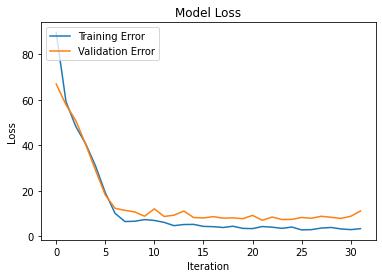

In [11]:
plt.plot(training_history_1.history['mse']) 
plt.plot(training_history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend(['Training Error', "Validation Error"], loc='upper left')
plt.show()

model.save("trained_sine_model")
saved_model = tf.keras.models.load_model("trained_sine_model")

In [ ]:
model.save("trained_sine_model") 
saved_model = tf.keras.models.load_model("trained_sine_model")